In [1]:
# pip install tushare
# pip install keras_sequential_ascii

In [2]:
# Part 1 - Data Preprocessing
# Importing the libraries导入需要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tushare as ts
import keras
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model 

In [3]:
# set the seed_num
import json
import os
import random
import tensorflow as tf
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)
from tensorflow.compat.v1.keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [4]:
# early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=30,
                          verbose=2)

mc = ModelCheckpoint(filepath='best_model.h5',
                     monitor='val_acc',
                     mode='max',
                     verbose=1,
                     save_best_only=True) 

In [5]:
# # 定义回调函数,用来监控训练情况
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = {'batch':[], 'epoch':[]}
#         self.accuracy = {'batch':[], 'epoch':[]}
#         self.val_loss = {'batch':[], 'epoch':[]}
#         self.val_acc = {'batch':[], 'epoch':[]}

#     def on_batch_end(self, batch, logs={}):
#         self.losses['batch'].append(logs.get('loss'))
#         self.accuracy['batch'].append(logs.get('acc'))
#         self.val_loss['batch'].append(logs.get('val_loss'))
#         self.val_acc['batch'].append(logs.get('val_acc'))

#     def on_epoch_end(self, batch, logs={}):
#         self.losses['epoch'].append(logs.get('loss'))
#         self.accuracy['epoch'].append(logs.get('acc'))
#         self.val_loss['epoch'].append(logs.get('val_loss'))
#         self.val_acc['epoch'].append(logs.get('val_acc'))

#     def loss_plot(self, loss_type):
#         iters = range(len(self.losses[loss_type]))
#         plt.figure()
#         # loss
#         plt.plot(iters, self.losses[loss_type], 'red', label='Training loss')
#         if loss_type == 'epoch':
#             # val_loss
#             plt.plot(iters, self.val_loss[loss_type], 'blue', label='Validation loss')
#         plt.grid(True)
#         plt.xlabel(loss_type)
#         plt.ylabel('loss')
#         plt.legend(loc="upper right")
#         plt.show()

In [6]:
# Importing the training set读入数据集
#下载数据接口介绍https://mp.weixin.qq.com/s/XoyACntxEXX3ZEqvECUbBg
data=ts.get_k_data('600000',start='2008-01-01',end='2020-12-31')#通过tushare的接口获取浦发银行的历史数据
print(data.shape)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
(3114, 7)


In [7]:
#显示数据集的前几行，查看样式
print(data.head())
all_data = data.iloc[:, 1:6]
print(all_data.head())

         date   open  close   high    low     volume    code
0  2008-01-02  8.168  8.293  8.634  7.898  131583.90  600000
1  2008-01-03  8.168  7.684  8.293  7.391  211346.56  600000
2  2008-01-04  7.702  8.170  8.307  7.491  139249.67  600000
3  2008-01-07  8.118  8.848  8.953  8.095  228043.01  600000
4  2008-01-08  8.896  8.939  9.121  8.850  161255.31  600000
    open  close   high    low     volume
0  8.168  8.293  8.634  7.898  131583.90
1  8.168  7.684  8.293  7.391  211346.56
2  7.702  8.170  8.307  7.491  139249.67
3  8.118  8.848  8.953  8.095  228043.01
4  8.896  8.939  9.121  8.850  161255.31


In [8]:
print(all_data.shape)

(3114, 5)


In [9]:
# Feature Scaling特征归一化
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1),)
all_data_scaled = sc.fit_transform(all_data)
print(all_data_scaled)
print('训练数据长度是:',len(all_data_scaled))

[[0.68836846 0.69292567 0.69966508 0.67603854 0.00771713]
 [0.68836846 0.64542547 0.67310538 0.63599747 0.01439697]
 [0.65199063 0.68333203 0.67419581 0.64389512 0.00835911]
 ...
 [0.76190476 0.75196943 0.73907625 0.76622966 0.033672  ]
 [0.75644028 0.74962951 0.73284524 0.75991155 0.04266218]
 [0.75565964 0.76366898 0.74452839 0.76386037 0.05196373]]
训练数据长度是: 3114


In [10]:
# Creating a data structure with 60 timesteps and 1 output
features = []
labels = []
for i in range(60, len(all_data_scaled)):
    features.append(all_data_scaled[i-60:i, ])
    labels.append(all_data_scaled[i, 1])
features, labels = np.array(features), np.array(labels)
features = np.reshape(features, (features.shape[0], features.shape[1], -1))
x_train,x_val,x_test,y_train,y_val,y_test= features[:2488],features[2488 :2799],features[2799:],labels[:2488],labels[2488 :2799],labels[2799:]
print('shape of x_train:',x_train.shape)
print('shape of x_val:',x_val.shape)
print('shape of x_test:',x_test.shape)
print('shape of y_train:',y_train.shape)
print('shape of y_val:',y_val.shape)
print('shape of y_test:',y_test.shape)

shape of x_train: (2488, 60, 5)
shape of x_val: (311, 60, 5)
shape of x_test: (255, 60, 5)
shape of y_train: (2488,)
shape of y_val: (311,)
shape of y_test: (255,)


In [11]:
# Part 2 - Building the LSTM
# Importing the Keras libraries and packages
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 5)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [12]:
#编译训练模型重点#
#编译训练模型重点#
#编译训练模型重点#

import keras 
from sklearn.model_selection import train_test_split
# Adding the output layer
regressor.add(Dense(units = 1))
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [13]:
print(regressor.summary()) # Summarize Model 模型可视化

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [14]:
from keras_sequential_ascii import keras2ascii
keras2ascii(regressor)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     60    5
                LSTM   LLLLL -------------------     11200    15.6%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                LSTM   LLLLL -------------------     20200    28.1%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                LSTM   LLLLL -------------------     20200    28.1%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                LSTM   LLLLL -------------------     20200    28.1%
                tanh   #####          50
             Dropout    | || -------------------         0     0.0%
                       #####          50
             

In [15]:
from keras.utils.vis_utils import plot_model  
plot_model(regressor, to_file='model.png', show_shapes=True, show_layer_names=True) # plot my model

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [16]:
history=regressor.fit(x_train, y_train, epochs =400,batch_size = 128,validation_data=(x_val, y_val),callbacks=[mc, earlystop])

Epoch 1/400
20/20 [==============================] - 2s 80ms/step - loss: 0.0498 - val_loss: 0.0017
Epoch 2/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0080 - val_loss: 0.0016
Epoch 3/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0059 - val_loss: 0.0026
Epoch 4/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 5/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 6/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 7/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 8/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 9/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 10/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0012

Epoch 81/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 7.6173e-04
Epoch 82/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 6.5987e-04
Epoch 83/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 9.0501e-04
Epoch 84/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 5.8499e-04
Epoch 85/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 5.6438e-04
Epoch 86/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 87/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 9.1379e-04
Epoch 88/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 89/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 6.7739e-04
Epoch 90/400
20/20 [==============================] - 0s 14ms/s

Epoch 159/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 4.3859e-04
Epoch 160/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 4.0214e-04
Epoch 161/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 5.5682e-04
Epoch 162/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 3.1296e-04
Epoch 163/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 3.6404e-04
Epoch 164/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 4.2370e-04
Epoch 165/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 4.4397e-04
Epoch 166/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 5.0449e-04
Epoch 167/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 3.3267e-04
Epoch 168/400
20/20 [=========================

20/20 [==============================] - 0s 14ms/step - loss: 8.2932e-04 - val_loss: 5.7988e-04
Epoch 236/400
20/20 [==============================] - 0s 14ms/step - loss: 8.9108e-04 - val_loss: 2.9911e-04
Epoch 237/400
20/20 [==============================] - 0s 14ms/step - loss: 8.4127e-04 - val_loss: 4.7768e-04
Epoch 238/400
20/20 [==============================] - 0s 14ms/step - loss: 8.6137e-04 - val_loss: 5.4261e-04
Epoch 239/400
20/20 [==============================] - 0s 14ms/step - loss: 9.9082e-04 - val_loss: 4.2812e-04
Epoch 240/400
20/20 [==============================] - 0s 14ms/step - loss: 9.1110e-04 - val_loss: 6.1111e-04
Epoch 241/400
20/20 [==============================] - 0s 14ms/step - loss: 9.2453e-04 - val_loss: 2.4280e-04
Epoch 242/400
20/20 [==============================] - 0s 14ms/step - loss: 8.7270e-04 - val_loss: 6.8595e-04
Epoch 243/400
20/20 [==============================] - 0s 14ms/step - loss: 8.5024e-04 - val_loss: 3.6985e-04
Epoch 244/400
20/20 [===

20/20 [==============================] - 0s 14ms/step - loss: 7.3906e-04 - val_loss: 2.8349e-04
Epoch 310/400
20/20 [==============================] - 0s 14ms/step - loss: 7.6358e-04 - val_loss: 2.2227e-04
Epoch 311/400
20/20 [==============================] - 0s 14ms/step - loss: 7.6356e-04 - val_loss: 3.5425e-04
Epoch 312/400
20/20 [==============================] - 0s 14ms/step - loss: 7.5479e-04 - val_loss: 2.2419e-04
Epoch 313/400
20/20 [==============================] - 0s 14ms/step - loss: 8.1953e-04 - val_loss: 3.7852e-04
Epoch 314/400
20/20 [==============================] - 0s 14ms/step - loss: 8.3350e-04 - val_loss: 2.1582e-04
Epoch 315/400
20/20 [==============================] - 0s 14ms/step - loss: 8.0575e-04 - val_loss: 6.2280e-04
Epoch 316/400
20/20 [==============================] - 0s 14ms/step - loss: 8.0513e-04 - val_loss: 2.1297e-04
Epoch 317/400
20/20 [==============================] - 0s 14ms/step - loss: 7.6189e-04 - val_loss: 2.1342e-04
Epoch 318/400
20/20 [===

20/20 [==============================] - 0s 14ms/step - loss: 7.1404e-04 - val_loss: 1.9494e-04
Epoch 384/400
20/20 [==============================] - 0s 14ms/step - loss: 7.6594e-04 - val_loss: 1.9605e-04
Epoch 385/400
20/20 [==============================] - 0s 14ms/step - loss: 7.5950e-04 - val_loss: 2.5344e-04
Epoch 386/400
20/20 [==============================] - 0s 14ms/step - loss: 7.3235e-04 - val_loss: 2.5819e-04
Epoch 387/400
20/20 [==============================] - 0s 14ms/step - loss: 7.2863e-04 - val_loss: 1.9071e-04
Epoch 388/400
20/20 [==============================] - 0s 14ms/step - loss: 6.9089e-04 - val_loss: 2.1492e-04
Epoch 389/400
20/20 [==============================] - 0s 14ms/step - loss: 7.2508e-04 - val_loss: 2.5926e-04
Epoch 390/400
20/20 [==============================] - 0s 14ms/step - loss: 7.5597e-04 - val_loss: 3.4475e-04
Epoch 391/400
20/20 [==============================] - 0s 14ms/step - loss: 7.3709e-04 - val_loss: 3.2904e-04
Epoch 392/400
20/20 [===

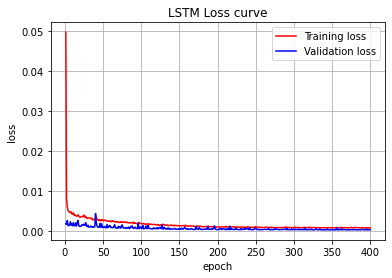

In [17]:
#画损失曲线图
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.title('LSTM Loss curve')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
sc_one = MinMaxScaler(feature_range = (0, 1))
sc_one.fit_transform(all_data.iloc[:, 1:2])
predicted_stock_train = regressor.predict(x_train)
predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
predicted_stock_test = regressor.predict(x_test)
predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)
real_price_train=sc_one.inverse_transform(np.reshape(y_train,(-1,1)))
real_price_test=sc_one.inverse_transform(np.reshape(y_test,(-1,1)))

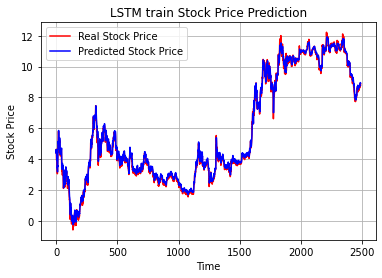

In [19]:
# Visualising the test results
plt.plot(real_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('LSTM train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

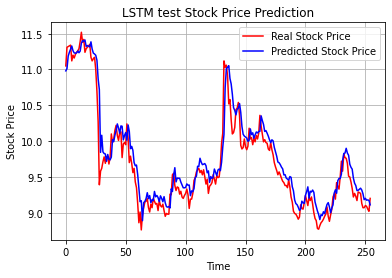

In [20]:
# Visualising the test results
plt.plot(real_price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('LSTM test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_test, real_price_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_stock_test, real_price_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_test, real_price_test)

r2=r2_score(predicted_stock_test, real_price_test)

print('LSTM模型的均方误差是: %.6f' % mse)
print('LSTM模型的均方根误差是: %.6f' % rmse)
print('LSTM模型的平均绝对误差是: %.6f' % mae)
print('LSTM模型的R-squared是: %.6f' % r2)

LSTM模型的均方误差是: 0.043080
LSTM模型的均方根误差是: 0.207558
LSTM模型的平均绝对误差是: 0.151054
LSTM模型的R-squared是: 0.903386


In [22]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [44]:
#GRU
regressorGRU = Sequential()
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],5)))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=50))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1))
regressorGRU.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
print(regressorGRU.summary()) # Summarize Model 模型可视化

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 60, 50)            8550      
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
gru_6 (GRU)                  (None, 60, 50)            15300     
_________________________________________________________________
dropout_11 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
gru_7 (GRU)                  (None, 50)               

In [46]:
from keras_sequential_ascii import keras2ascii
keras2ascii(regressorGRU)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     60    5
                 GRU   LLLLL -------------------      8550    15.7%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                 GRU   LLLLL -------------------     15300    28.1%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                 GRU   LLLLL -------------------     15300    28.1%
                tanh   #####     60   50
             Dropout    | || -------------------         0     0.0%
                       #####     60   50
                 GRU   LLLLL -------------------     15300    28.1%
                tanh   #####          50
             Dropout    | || -------------------         0     0.0%
                       #####          50
             

In [47]:
#from keras.utils import plot_model 
#plot_model(regressorGRU, to_file='model.png', show_shapes=True, show_layer_names=True) # plot my model

In [48]:
history=regressorGRU.fit(x_train, y_train, epochs=400, batch_size=128,validation_data=(x_val, y_val), callbacks=[mc, earlystop])

Epoch 1/400
20/20 [==============================] - 1s 71ms/step - loss: 0.0625 - val_loss: 0.0184
Epoch 2/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0124 - val_loss: 9.7819e-04
Epoch 3/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0011
Epoch 4/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0061 - val_loss: 7.8074e-04
Epoch 5/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 7.2003e-04
Epoch 6/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 7/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0017
Epoch 8/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 9/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0043 - val_loss: 9.6688e-04
Epoch 10/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0039 - 

Epoch 80/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 4.0388e-04
Epoch 81/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 5.8483e-04
Epoch 82/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 4.0025e-04
Epoch 83/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 4.0295e-04
Epoch 84/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 4.5054e-04
Epoch 85/400
20/20 [==============================] - 0s 14ms/step - loss: 0.0017 - val_loss: 3.9171e-04
Epoch 86/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 4.3105e-04
Epoch 87/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0016 - val_loss: 7.4408e-04
Epoch 88/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 4.1120e-04
Epoch 89/400
20/20 [==============================] - 0

20/20 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 5.1989e-04
Epoch 158/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 4.3176e-04
Epoch 159/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 3.5345e-04
Epoch 160/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 4.7221e-04
Epoch 161/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 8.3859e-04
Epoch 162/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 2.7507e-04
Epoch 163/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 3.8944e-04
Epoch 164/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 4.9002e-04
Epoch 165/400
20/20 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 4.3361e-04
Epoch 166/400
20/20 [==============================] - 0s 13

20/20 [==============================] - 0s 13ms/step - loss: 9.5636e-04 - val_loss: 2.4724e-04
Epoch 233/400
20/20 [==============================] - 0s 13ms/step - loss: 8.4329e-04 - val_loss: 2.5031e-04
Epoch 234/400
20/20 [==============================] - 0s 13ms/step - loss: 8.3815e-04 - val_loss: 2.4195e-04
Epoch 235/400
20/20 [==============================] - 0s 13ms/step - loss: 7.9725e-04 - val_loss: 7.9211e-04
Epoch 236/400
20/20 [==============================] - 0s 13ms/step - loss: 8.5060e-04 - val_loss: 3.4179e-04
Epoch 237/400
20/20 [==============================] - 0s 13ms/step - loss: 8.1225e-04 - val_loss: 2.5081e-04
Epoch 238/400
20/20 [==============================] - 0s 13ms/step - loss: 8.2553e-04 - val_loss: 4.5451e-04
Epoch 239/400
20/20 [==============================] - 0s 13ms/step - loss: 9.6298e-04 - val_loss: 2.2992e-04
Epoch 240/400
20/20 [==============================] - 0s 13ms/step - loss: 8.9219e-04 - val_loss: 5.7694e-04
Epoch 241/400
20/20 [===

20/20 [==============================] - 0s 13ms/step - loss: 7.7339e-04 - val_loss: 2.1571e-04
Epoch 307/400
20/20 [==============================] - 0s 13ms/step - loss: 6.9011e-04 - val_loss: 1.9282e-04
Epoch 308/400
20/20 [==============================] - 0s 13ms/step - loss: 7.5841e-04 - val_loss: 1.9321e-04
Epoch 309/400
20/20 [==============================] - 0s 13ms/step - loss: 7.7177e-04 - val_loss: 3.6198e-04
Epoch 310/400
20/20 [==============================] - 0s 13ms/step - loss: 7.4596e-04 - val_loss: 1.9196e-04
Epoch 311/400
20/20 [==============================] - 0s 13ms/step - loss: 7.0397e-04 - val_loss: 0.0011
Epoch 312/400
20/20 [==============================] - 0s 13ms/step - loss: 7.2178e-04 - val_loss: 3.7980e-04
Epoch 313/400
20/20 [==============================] - 0s 13ms/step - loss: 7.5143e-04 - val_loss: 6.4749e-04
Epoch 314/400
20/20 [==============================] - 0s 13ms/step - loss: 7.9200e-04 - val_loss: 2.2347e-04
Epoch 315/400
20/20 [=======

20/20 [==============================] - 0s 13ms/step - loss: 7.7598e-04 - val_loss: 3.0394e-04
Epoch 381/400
20/20 [==============================] - 0s 13ms/step - loss: 8.2739e-04 - val_loss: 1.9550e-04
Epoch 382/400
20/20 [==============================] - 0s 13ms/step - loss: 8.0107e-04 - val_loss: 3.9818e-04
Epoch 383/400
20/20 [==============================] - 0s 13ms/step - loss: 7.0961e-04 - val_loss: 1.9048e-04
Epoch 384/400
20/20 [==============================] - 0s 13ms/step - loss: 7.3357e-04 - val_loss: 1.7748e-04
Epoch 385/400
20/20 [==============================] - 0s 13ms/step - loss: 7.3798e-04 - val_loss: 2.2273e-04
Epoch 00385: early stopping


In [49]:
#保存模型的方法
# # serialize model to JSON
# model_json = regressorGRU.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# regressorGRU.save_weights("model.h5")
# print("Saved model to disk")

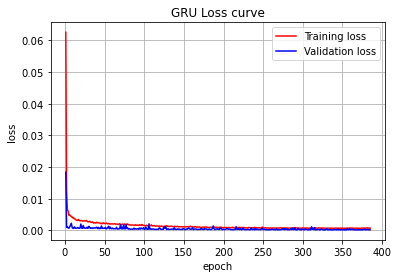

In [50]:
#画损失曲线图
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.title('GRU Loss curve')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [51]:
sc_one = MinMaxScaler(feature_range = (0, 1))
sc_one.fit_transform(all_data.iloc[:, 1:2])
predicted_stock_train = regressorGRU.predict(x_train)
predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
predicted_stock_test = regressorGRU.predict(x_test)
predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)
real_price_train=sc_one.inverse_transform(np.reshape(y_train,(-1,1)))
real_price_test=sc_one.inverse_transform(np.reshape(y_test,(-1,1)))

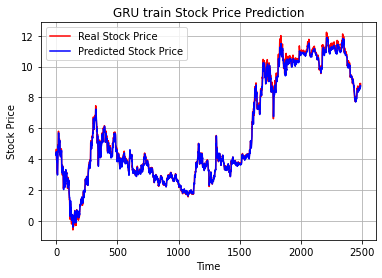

In [52]:
# Visualising the test results
plt.plot(real_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('GRU train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

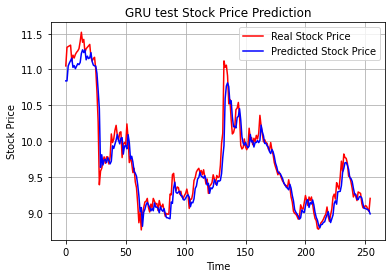

In [53]:
# Visualising the test results
plt.plot(real_price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('GRU test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_test, real_price_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_stock_test, real_price_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_test, real_price_test)

r2=r2_score(predicted_stock_test, real_price_test)

print('GRU模型的均方误差是: %.6f' % mse)
print('GRU模型的均方根误差是: %.6f' % rmse)
print('GRU模型的平均绝对误差是: %.6f' % mae)
print('GRU模型的R-squared是: %.6f' % r2)

GRU模型的均方误差是: 0.030858
GRU模型的均方根误差是: 0.175665
GRU模型的平均绝对误差是: 0.115244
GRU模型的R-squared是: 0.928462


In [34]:
# BiLSTM
regressorBiLSTM = Sequential()
# firt LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(x_train.shape[1],5), merge_mode='concat'))
# second LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
regressorBiLSTM.add(Dropout(0.1))
# third LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True)))
# fourth LSTM layer
regressorBiLSTM.add(Bidirectional(LSTM(units=50)))
# output layer
regressorBiLSTM.add(Dense(units=1))
# compile the RNN
regressorBiLSTM.compile(optimizer='adam', loss='mean_squared_error') #optimizer选择不同的算法优化器

In [35]:
print(regressorBiLSTM.summary()) # Summarize Model 模型可视化

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 60, 100)           22400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 100)           60400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 60, 100)           60400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 203,701
Trainable params: 203,701
Non-trainable params: 0
________________________________________________

In [36]:
from keras_sequential_ascii import keras2ascii
keras2ascii(regressorBiLSTM)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     60    5
       Bidirectional   ????? -------------------     22400    11.0%
                       #####     60  100
       Bidirectional   ????? -------------------     60400    29.7%
                       #####     60  100
             Dropout    | || -------------------         0     0.0%
                       #####     60  100
       Bidirectional   ????? -------------------     60400    29.7%
                       #####     60  100
       Bidirectional   ????? -------------------     60400    29.7%
                       #####         100
               Dense   XXXXX -------------------       101     0.0%
                       #####           1


In [37]:
#from keras.utils import plot_model 
#plot_model(regressorBiLSTM, to_file='model.png', show_shapes=True, show_layer_names=True) # plot my model

In [38]:
# fit to the training set
history=regressorBiLSTM.fit(x_train, y_train, epochs=400, batch_size=128,validation_data=(x_val, y_val),callbacks=[mc, earlystop])

Epoch 1/400
20/20 [==============================] - 3s 151ms/step - loss: 0.0403 - val_loss: 0.0137
Epoch 2/400
20/20 [==============================] - 1s 26ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 3/400
20/20 [==============================] - 1s 26ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 4/400
20/20 [==============================] - 1s 26ms/step - loss: 0.0018 - val_loss: 9.6957e-04
Epoch 5/400
20/20 [==============================] - 1s 26ms/step - loss: 0.0014 - val_loss: 8.1445e-04
Epoch 6/400
20/20 [==============================] - 1s 27ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/400
20/20 [==============================] - 1s 27ms/step - loss: 0.0012 - val_loss: 7.6689e-04
Epoch 8/400
20/20 [==============================] - 1s 26ms/step - loss: 0.0011 - val_loss: 8.3179e-04
Epoch 9/400
20/20 [==============================] - 1s 27ms/step - loss: 0.0011 - val_loss: 7.3471e-04
Epoch 10/400
20/20 [==============================] - 1s 26ms/step - loss: 0.00

20/20 [==============================] - 1s 26ms/step - loss: 5.0125e-04 - val_loss: 2.9400e-04
Epoch 78/400
20/20 [==============================] - 1s 26ms/step - loss: 4.5765e-04 - val_loss: 7.2127e-04
Epoch 79/400
20/20 [==============================] - 1s 26ms/step - loss: 4.8984e-04 - val_loss: 2.8862e-04
Epoch 80/400
20/20 [==============================] - 1s 26ms/step - loss: 4.9011e-04 - val_loss: 4.2530e-04
Epoch 81/400
20/20 [==============================] - 1s 26ms/step - loss: 5.1772e-04 - val_loss: 4.0773e-04
Epoch 82/400
20/20 [==============================] - 1s 26ms/step - loss: 4.5517e-04 - val_loss: 4.0473e-04
Epoch 83/400
20/20 [==============================] - 1s 26ms/step - loss: 5.7694e-04 - val_loss: 2.9842e-04
Epoch 84/400
20/20 [==============================] - 1s 26ms/step - loss: 6.0498e-04 - val_loss: 2.9518e-04
Epoch 85/400
20/20 [==============================] - 1s 26ms/step - loss: 4.3765e-04 - val_loss: 2.8440e-04
Epoch 86/400
20/20 [============

Epoch 152/400
20/20 [==============================] - 1s 27ms/step - loss: 3.6685e-04 - val_loss: 2.2029e-04
Epoch 153/400
20/20 [==============================] - 1s 27ms/step - loss: 3.2730e-04 - val_loss: 2.3481e-04
Epoch 154/400
20/20 [==============================] - 1s 27ms/step - loss: 3.1658e-04 - val_loss: 2.2207e-04
Epoch 155/400
20/20 [==============================] - 1s 27ms/step - loss: 3.1835e-04 - val_loss: 5.0455e-04
Epoch 156/400
20/20 [==============================] - 1s 26ms/step - loss: 3.7032e-04 - val_loss: 2.6302e-04
Epoch 157/400
20/20 [==============================] - 1s 26ms/step - loss: 3.3931e-04 - val_loss: 3.0407e-04
Epoch 158/400
20/20 [==============================] - 1s 26ms/step - loss: 3.2821e-04 - val_loss: 2.1343e-04
Epoch 159/400
20/20 [==============================] - 1s 27ms/step - loss: 3.7959e-04 - val_loss: 5.2729e-04
Epoch 160/400
20/20 [==============================] - 1s 27ms/step - loss: 3.2993e-04 - val_loss: 3.6841e-04
Epoch 161/

20/20 [==============================] - 1s 27ms/step - loss: 2.7521e-04 - val_loss: 2.2070e-04
Epoch 227/400
20/20 [==============================] - 1s 26ms/step - loss: 2.4929e-04 - val_loss: 1.9092e-04
Epoch 228/400
20/20 [==============================] - 1s 26ms/step - loss: 2.5767e-04 - val_loss: 1.9243e-04
Epoch 229/400
20/20 [==============================] - 1s 27ms/step - loss: 2.5772e-04 - val_loss: 3.3110e-04
Epoch 230/400
20/20 [==============================] - 1s 27ms/step - loss: 3.1380e-04 - val_loss: 1.9333e-04
Epoch 231/400
20/20 [==============================] - 1s 27ms/step - loss: 2.9689e-04 - val_loss: 1.8674e-04
Epoch 232/400
20/20 [==============================] - 1s 27ms/step - loss: 2.8723e-04 - val_loss: 9.9211e-04
Epoch 233/400
20/20 [==============================] - 1s 27ms/step - loss: 3.2637e-04 - val_loss: 2.5522e-04
Epoch 234/400
20/20 [==============================] - 1s 27ms/step - loss: 2.8397e-04 - val_loss: 3.3656e-04
Epoch 235/400
20/20 [===

20/20 [==============================] - 1s 26ms/step - loss: 2.5526e-04 - val_loss: 1.8027e-04
Epoch 301/400
20/20 [==============================] - 1s 27ms/step - loss: 2.7668e-04 - val_loss: 1.8398e-04
Epoch 302/400
20/20 [==============================] - 1s 27ms/step - loss: 2.5169e-04 - val_loss: 2.6550e-04
Epoch 303/400
20/20 [==============================] - 1s 27ms/step - loss: 2.4271e-04 - val_loss: 2.3335e-04
Epoch 304/400
20/20 [==============================] - 1s 27ms/step - loss: 2.9285e-04 - val_loss: 3.1870e-04
Epoch 305/400
20/20 [==============================] - 1s 27ms/step - loss: 2.6851e-04 - val_loss: 1.9371e-04
Epoch 306/400
20/20 [==============================] - 1s 27ms/step - loss: 2.5389e-04 - val_loss: 1.7870e-04
Epoch 307/400
20/20 [==============================] - 1s 26ms/step - loss: 2.4167e-04 - val_loss: 2.0059e-04
Epoch 308/400
20/20 [==============================] - 1s 27ms/step - loss: 2.8263e-04 - val_loss: 2.1988e-04
Epoch 309/400
20/20 [===

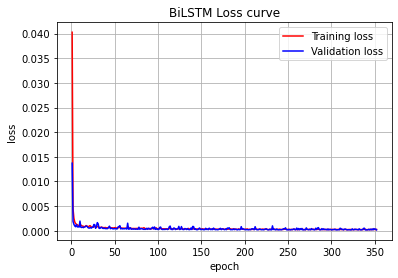

In [39]:
#画损失曲线图
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.title('BiLSTM Loss curve')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [40]:
sc_one = MinMaxScaler(feature_range = (0, 1))
sc_one.fit_transform(all_data.iloc[:, 1:2])
predicted_stock_train = regressorBiLSTM.predict(x_train)
predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
predicted_stock_test = regressorBiLSTM.predict(x_test)
predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)
real_price_train=sc_one.inverse_transform(np.reshape(y_train,(-1,1)))
real_price_test=sc_one.inverse_transform(np.reshape(y_test,(-1,1)))

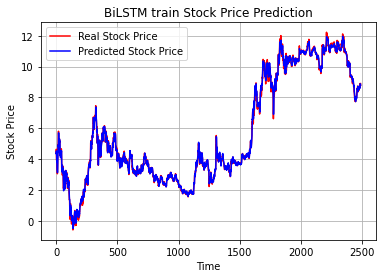

In [41]:
# Visualising the test results
plt.plot(real_price_train, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('BiLSTM train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

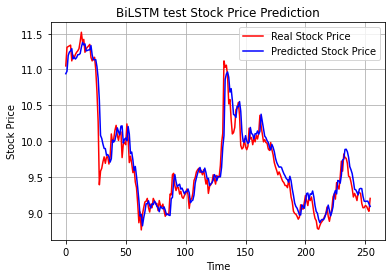

In [42]:
# Visualising the test results
plt.plot(real_price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('BiLSTM test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_stock_test, real_price_test)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(predicted_stock_test, real_price_test))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_stock_test, real_price_test)

r2=r2_score(predicted_stock_test, real_price_test)

print('BiLSTM模型的均方误差是: %.6f' % mse)
print('BiLSTM模型的均方根误差是: %.6f' % rmse)
print('BiLSTM模型的平均绝对误差是: %.6f' % mae)
print('BiLSTM模型的R-squared是: %.6f' % r2)

BiLSTM模型的均方误差是: 0.033015
BiLSTM模型的均方根误差是: 0.181701
BiLSTM模型的平均绝对误差是: 0.125192
BiLSTM模型的R-squared是: 0.928253
